In [529]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import networkx.algorithms.isomorphism as iso
import typedb
import pickle
import pandas as pd
import azlib.queries as azq
import matplotlib.pyplot as plt
import operator
from tqdm import tqdm
from typedb.client import *
from kglib.utils.graph.query.query_graph import QueryGraphAZ
from kglib.utils.graph.thing.queries_to_networkx_graph import build_graph_from_queries
from typing import List, Dict
from tqdm import tqdm
from gensim.models import Word2Vec

DATABASE = "orbit"
ADDRESS = "localhost:1729"

client = TypeDB.core_client(ADDRESS)
session = client.session(DATABASE, SessionType.DATA)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
def get_id_name_map(session: client.session) -> tuple:
    """Build the ID-Entity lookup tables for the three entities in the cocktail graph:
        - compound-ingredient
        - non-compound-ingredient
        - flavor-compound
    Args:
        session: Session connected to the TypeDB instance.
    Return:
        (tuple): map_c, map_n, map_f
    """
    with session.transaction(TransactionType.READ) as tx:
        # f: flavor-compound
        # c: compound-ingredient
        # n: non-compound-ingredient
        c_iterator = tx.query().match("match $c isa compound-ingredient, has name $cn;")
        n_iterator = tx.query().match("match $n isa non-compound-ingredient, has name $nn;")
        f_iterator = tx.query().match("match $f isa flavor-compound, has name $fn;")

        map_c = {}
        map_n = {}
        map_f = {}

        for c in c_iterator:
            map_c[c.get("c").get_iid()] = c.get("cn").get_value()
        for n in n_iterator:
            map_n[n.get("n").get_iid()] = n.get("nn").get_value()
        for f in f_iterator:
            map_f[f.get("f").get_iid()] = f.get("fn").get_value()
        
    return map_c, map_n, map_f

map_c, map_n, map_f = get_id_name_map(session)
print(f'\nCompound-Ingredient Count: {len(map_c)}')
for k, v in list(map_c.items())[:10]:
    print(f'{k}: {v}')

print(f'\nNon-Ingredient Count: {len(map_n)}')
for k, v in list(map_n.items())[:10]:
    print(f'{k}: {v}')

print(f'\nFlavor-Compound Count: {len(map_f)}')
for k, v in list(map_f.items())[:10]:
    print(f'{k}: {v}')


Compound-Ingredient Count: 46
0x966e8003800000000000000d: cider
0x966e80038000000000000000: beer
0x966e80038000000000000008: butter
0x966e80038000000000000009: mint
0x966e8003800000000000000a: gin
0x966e80038000000000000001: vanilla
0x966e80038000000000000005: pineapple
0x966e8003800000000000000f: cinnamon
0x966e8003800000000000000c: brandy
0x966e8003800000000000000e: champagne

Non-Ingredient Count: 285
0x966e8002800000000000000c: blackcurrant squash
0x966e8002800000000000000b: anis
0x966e80028000000000000001: marjoram leaves
0x966e8002800000000000000e: midori melon liqueur
0x966e8002800000000000000d: sirup of roses
0x966e80028000000000000000: worcestershire sauce
0x966e80028000000000000007: 7-up
0x966e80028000000000000002: can
0x966e80028000000000000008: raspberry syrup
0x966e80028000000000000004: kummel

Flavor-Compound Count: 1118
0x966e80018000000000000001: 3-methyl-2-oxobutanoic acid
0x966e80018000000000000009: trans-2-octen-1-ol
0x966e8001800000000000000c: sabinene
0x966e800180

In [210]:
for non_compound_ingredient in map_n.items():
    if str(g) in non_compound_ingredient:
        seed_node = non_compound_ingredient[0]
        print(seed_node)

0x966e8002800000000000000a


In [222]:
with open(
    "/Users/kostaspsychogyio/Desktop/zess-acd/metapath_extraction/data/graphs.pkl",
    "rb",
) as f:
    graphs = pickle.load(f)


In [532]:
nx.nodes(graphs[0])

NodeView((<used-with, 0xaa828002800000000000001f>, <compound-ingredient, 0x966e8003800000000000000c>, <flavor-compound, 0x966e80018000000000000041>, <compound-ingredient, 0x966e8003800000000000002d>, <non-compound-ingredient, 0x966e8002800000000000000a>, <non-compound-ingredient, 0x966e80028000000000000008>, <used-with, 0xaa8280028000000000000012>, <bound-to, 0xaa8280018000000000000869>, <bound-to, 0xaa8280018000000000001c2c>))

pineapple juice
Nodes:


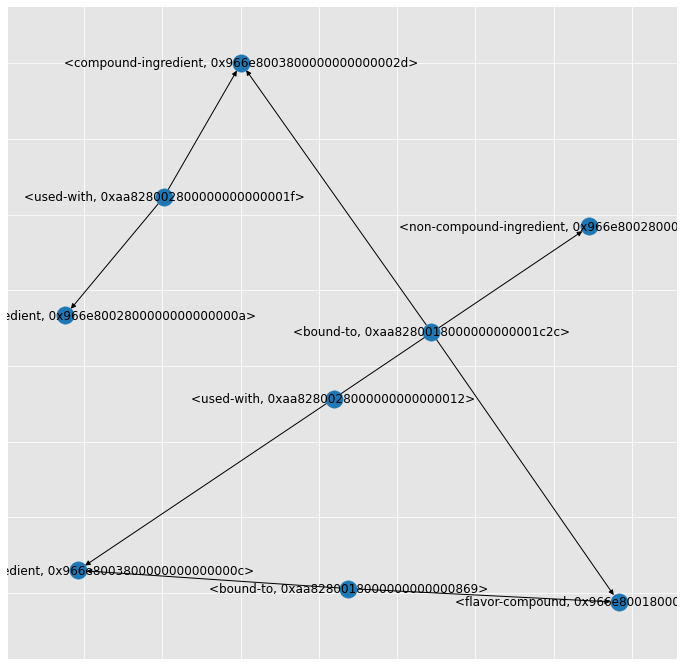

In [533]:
nodes = []
for g in graphs:
    print(g)
    print('Nodes:')
    nodes.append(g.nodes)
    plt.figure(figsize=(12,12)) 
    nx.draw_networkx(g, with_labels=True)
    break

In [511]:
#This function sorts the NetworkX extracted paths and returns a list of nodes in the right order
def sort_graph_nodes(g, seed):

    df = nx.to_pandas_edgelist(g)
#     if seed == '0x966e800180000000000003c2':
#         print(df)
    update_pointer = seed
    stack = []
    while len(stack) < 2*len(g.nodes)-2:
        for element_source, element_target in zip(df["source"].tolist(), df["target"].tolist()):
            element_source = str(element_source)
            element_target = str(element_target)
            
            if update_pointer in element_source:
                update_pointer = element_target
                stack.append(element_source)
                stack.append(element_target)
            elif update_pointer in element_target:
                update_pointer = element_source
                stack.append(element_target)
                stack.append(element_source)

    path = []
    for i in stack:
        if i not in path:
            path.append(i)

    nodes_path = []
    for i in path:
        if "used-with" in i or "bound-to" in i:
            pass
        else:
            nodes_path.append(i)


    nodes_path_f = []
    for node in nodes_path:
        flag = False
        for non_compound_ingredient in map_n.items():
            if non_compound_ingredient[0] in node:
                nodes_path_f.append(non_compound_ingredient[1])
                flag = True
                break

        if not flag:
            for compound_ingredient in map_c.items():
                if compound_ingredient[0] in node:
                    nodes_path_f.append(compound_ingredient[1])
                    break
        if not flag:        
            for flavor_compound in map_f.items():
                if flavor_compound[0] in node:
                    nodes_path_f.append(flavor_compound[1])
                    break        

    return nodes_path_f

In [227]:
#Extract all meta-path instances for each meta-path pattern using the function above
nodes_paths = []
for idx, graph in tqdm(enumerate(graphs)):
    #print(graph)
    for non_compound_ingredient in map_n.items():
        if str(graph) in non_compound_ingredient:
            seed_node = non_compound_ingredient[0]
#             print('ok', seed_node)
            nodes_path_f = sort_graph_nodes(graph, seed_node)
#             print(nodes_path_f)
            nodes_paths.append(nodes_path_f)
    for compound_ingredient in map_c.items():
        if str(graph) in compound_ingredient:
            seed_node = compound_ingredient[0]
            nodes_path_f = sort_graph_nodes(graph, seed_node)
#             print(nodes_path_f)
            nodes_paths.append(nodes_path_f)
    for flavor_compound in map_f.items():
        if str(graph) in flavor_compound:
            seed_node = flavor_compound[0]
#             print('ok', idx, seed_node)
            nodes_path_f = sort_graph_nodes(graph, seed_node)
#             print(nodes_path_f)
            nodes_paths.append(nodes_path_f)

47028it [01:12, 559.99it/s]

                                    source  \
0  <used-with, 0xaa828002800000000000005b>   
1  <used-with, 0xaa828002800000000000005b>   
2  <used-with, 0xaa828002800000000000005d>   
3  <used-with, 0xaa828002800000000000005d>   
4   <bound-to, 0xaa8280018000000000001172>   
5   <bound-to, 0xaa8280018000000000001172>   
6   <bound-to, 0xaa8280018000000000000af9>   
7   <bound-to, 0xaa8280018000000000000af9>   

                                              target  \
0  <non-compound-ingredient, 0x966e80028000000000...   
1  <compound-ingredient, 0x966e8003800000000000001c>   
2  <compound-ingredient, 0x966e80038000000000000010>   
3  <non-compound-ingredient, 0x966e80028000000000...   
4  <compound-ingredient, 0x966e8003800000000000001c>   
5      <flavor-compound, 0x966e800180000000000002c1>   
6  <compound-ingredient, 0x966e80038000000000000010>   
7      <flavor-compound, 0x966e800180000000000003c2>   

                         type  
0        ingredient-used-with  
1        ingredi

78496it [02:06, 620.25it/s]


In [270]:
#n = [i for j in nodes_paths for i in j]

In [513]:
#code to generate the plots below (how frequently ingredients are met in the meta-path instances)
d = Counter(n)

ingredients_dict = {}
for key, val in zip(d.keys(), d.values()):
    if key not in map_f.values():
        ingredients_dict[key] = val
        
sorted_ingredients_dict = {k: v for k, v in sorted(ingredients_dict.items(), key=lambda item: item[1])}


x_axis = list(sorted_ingredients_dict.keys())[:20]
y_axis = list(sorted_ingredients_dict.values())[:20]

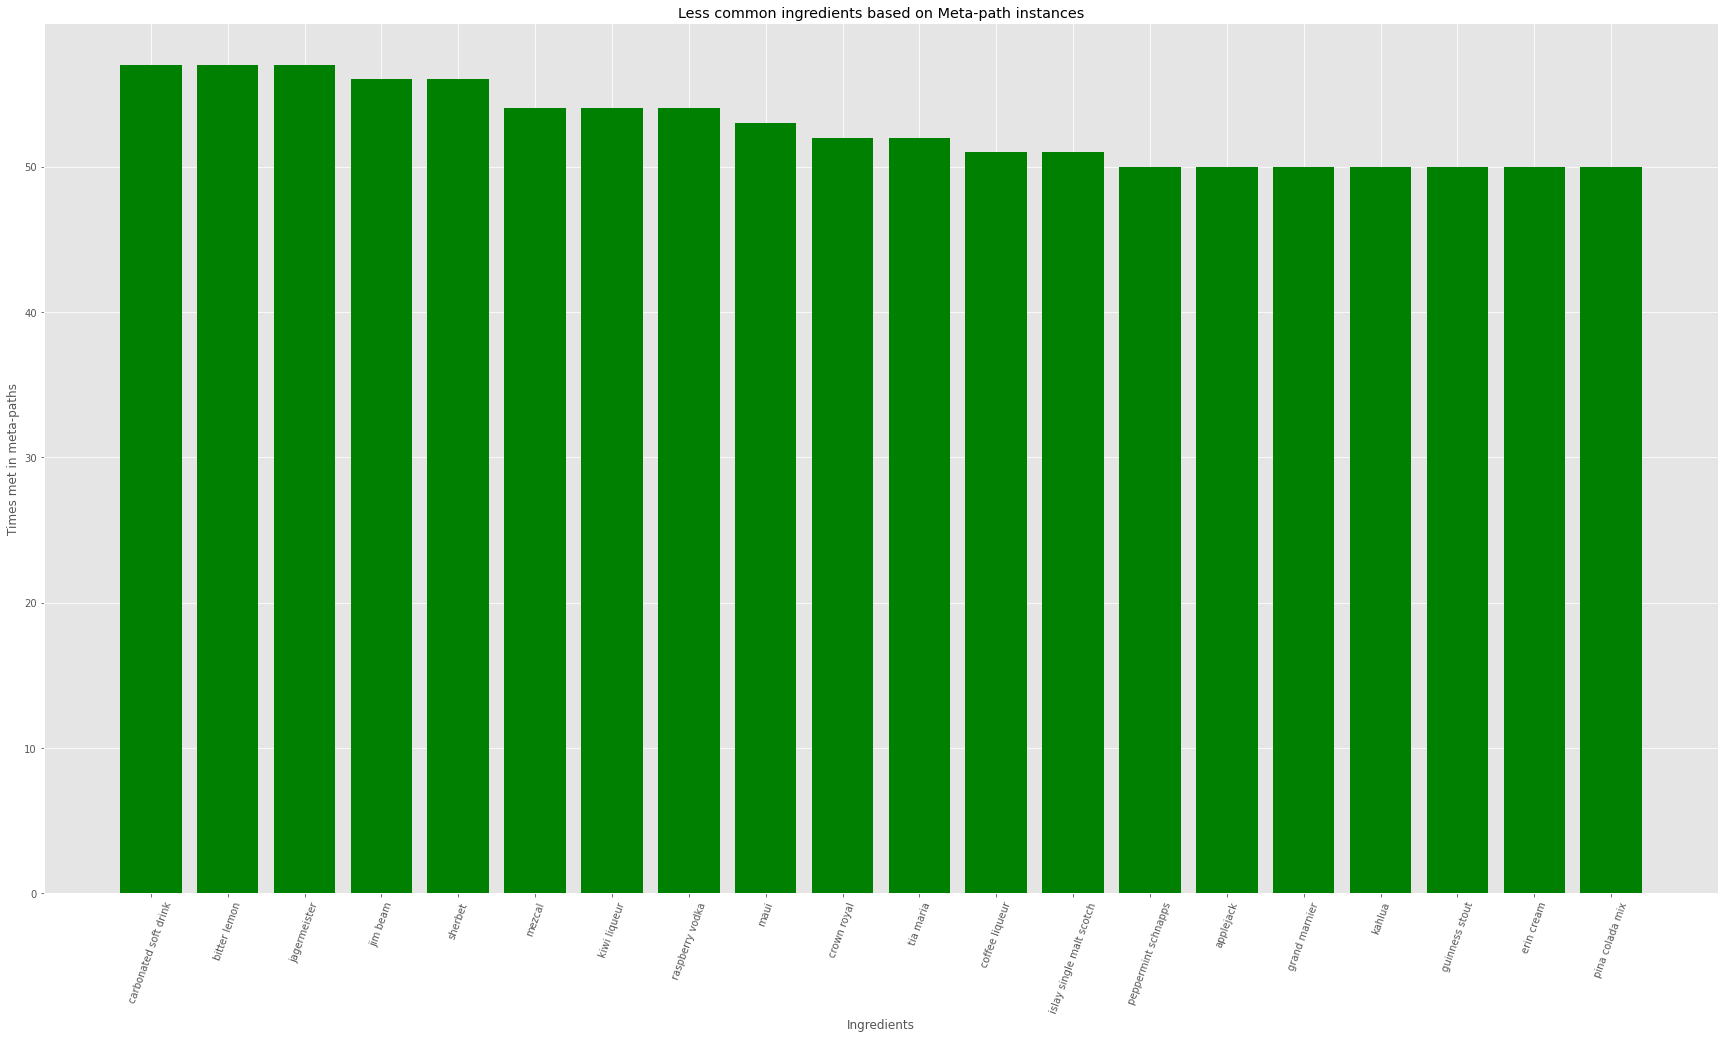

In [514]:
plt.style.use('ggplot')
plt.figure(figsize=(30, 16))

x_pos = [i for i, _ in enumerate(x_axis)]

plt.bar(x_axis[::-1], y_axis[::-1], color='green')
plt.xlabel("Ingredients")
plt.ylabel("Times met in meta-paths")
plt.title("Less common ingredients based on Meta-path instances")
plt.xticks(rotation=70)
plt.xticks(x_pos, x_axis)

plt.show()

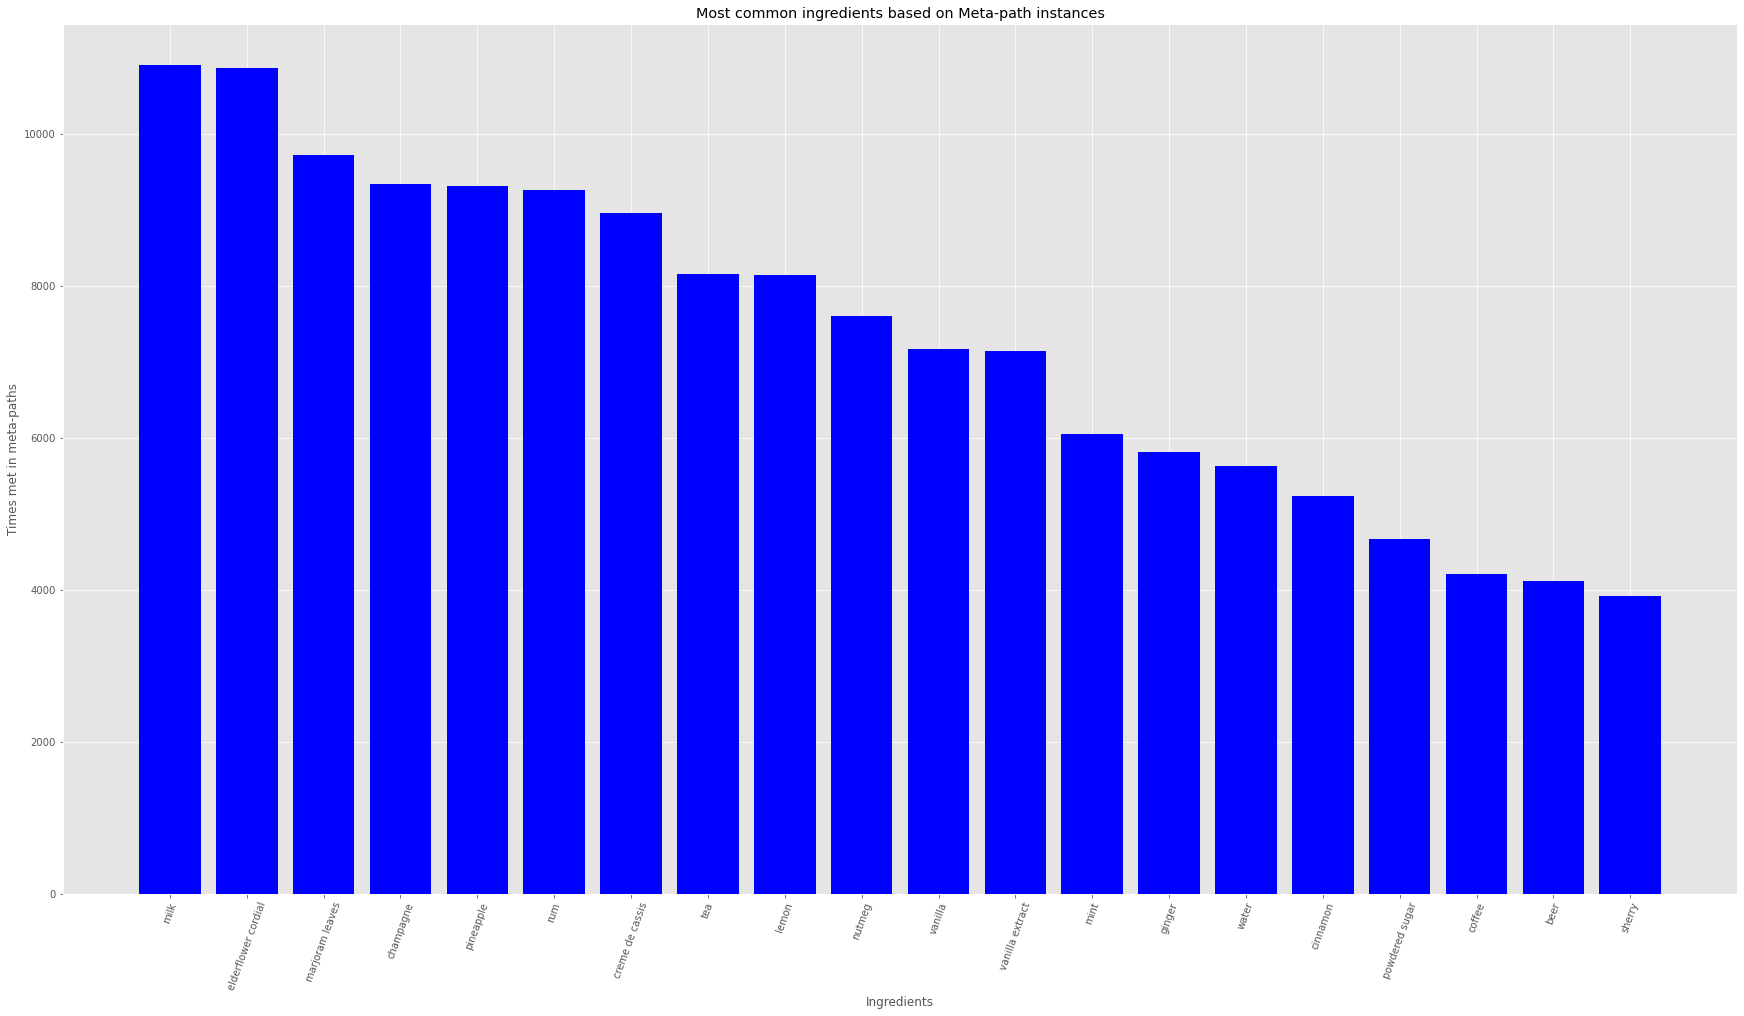

In [516]:
x_axis = list(sorted_ingredients_dict.keys())[-20:]
y_axis = list(sorted_ingredients_dict.values())[-20:]


plt.style.use('ggplot')
plt.figure(figsize=(30, 16))

x_pos = [i for i, _ in enumerate(x_axis)]

plt.bar(x_axis[::-1], y_axis[::-1], color='blue')
plt.xlabel("Ingredients")
plt.ylabel("Times met in meta-paths")
plt.title("Most common ingredients based on Meta-path instances")
plt.xticks(rotation=70)
plt.xticks(x_pos, x_axis)

plt.show()

In [518]:
#train the skip-gram and generate recommendations

model = Word2Vec(nodes_paths, window=3, min_count=0, sg=1, workers=2)
model.wv.vectors.shape
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

In [519]:
vectors, ings = [], []
for i in map_c.values():
    ings.append(i)
    vector = model.wv[i]
    vectors.append(vector)
for i in map_n.values():
    try:
        vector = model.wv[i]
        vectors.append(vector)
        ings.append(i)
    except:
        pass

In [328]:
#plot the learned node embeddings
from sklearn.manifold import TSNE
transform = TSNE  # PCA


trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(vectors)

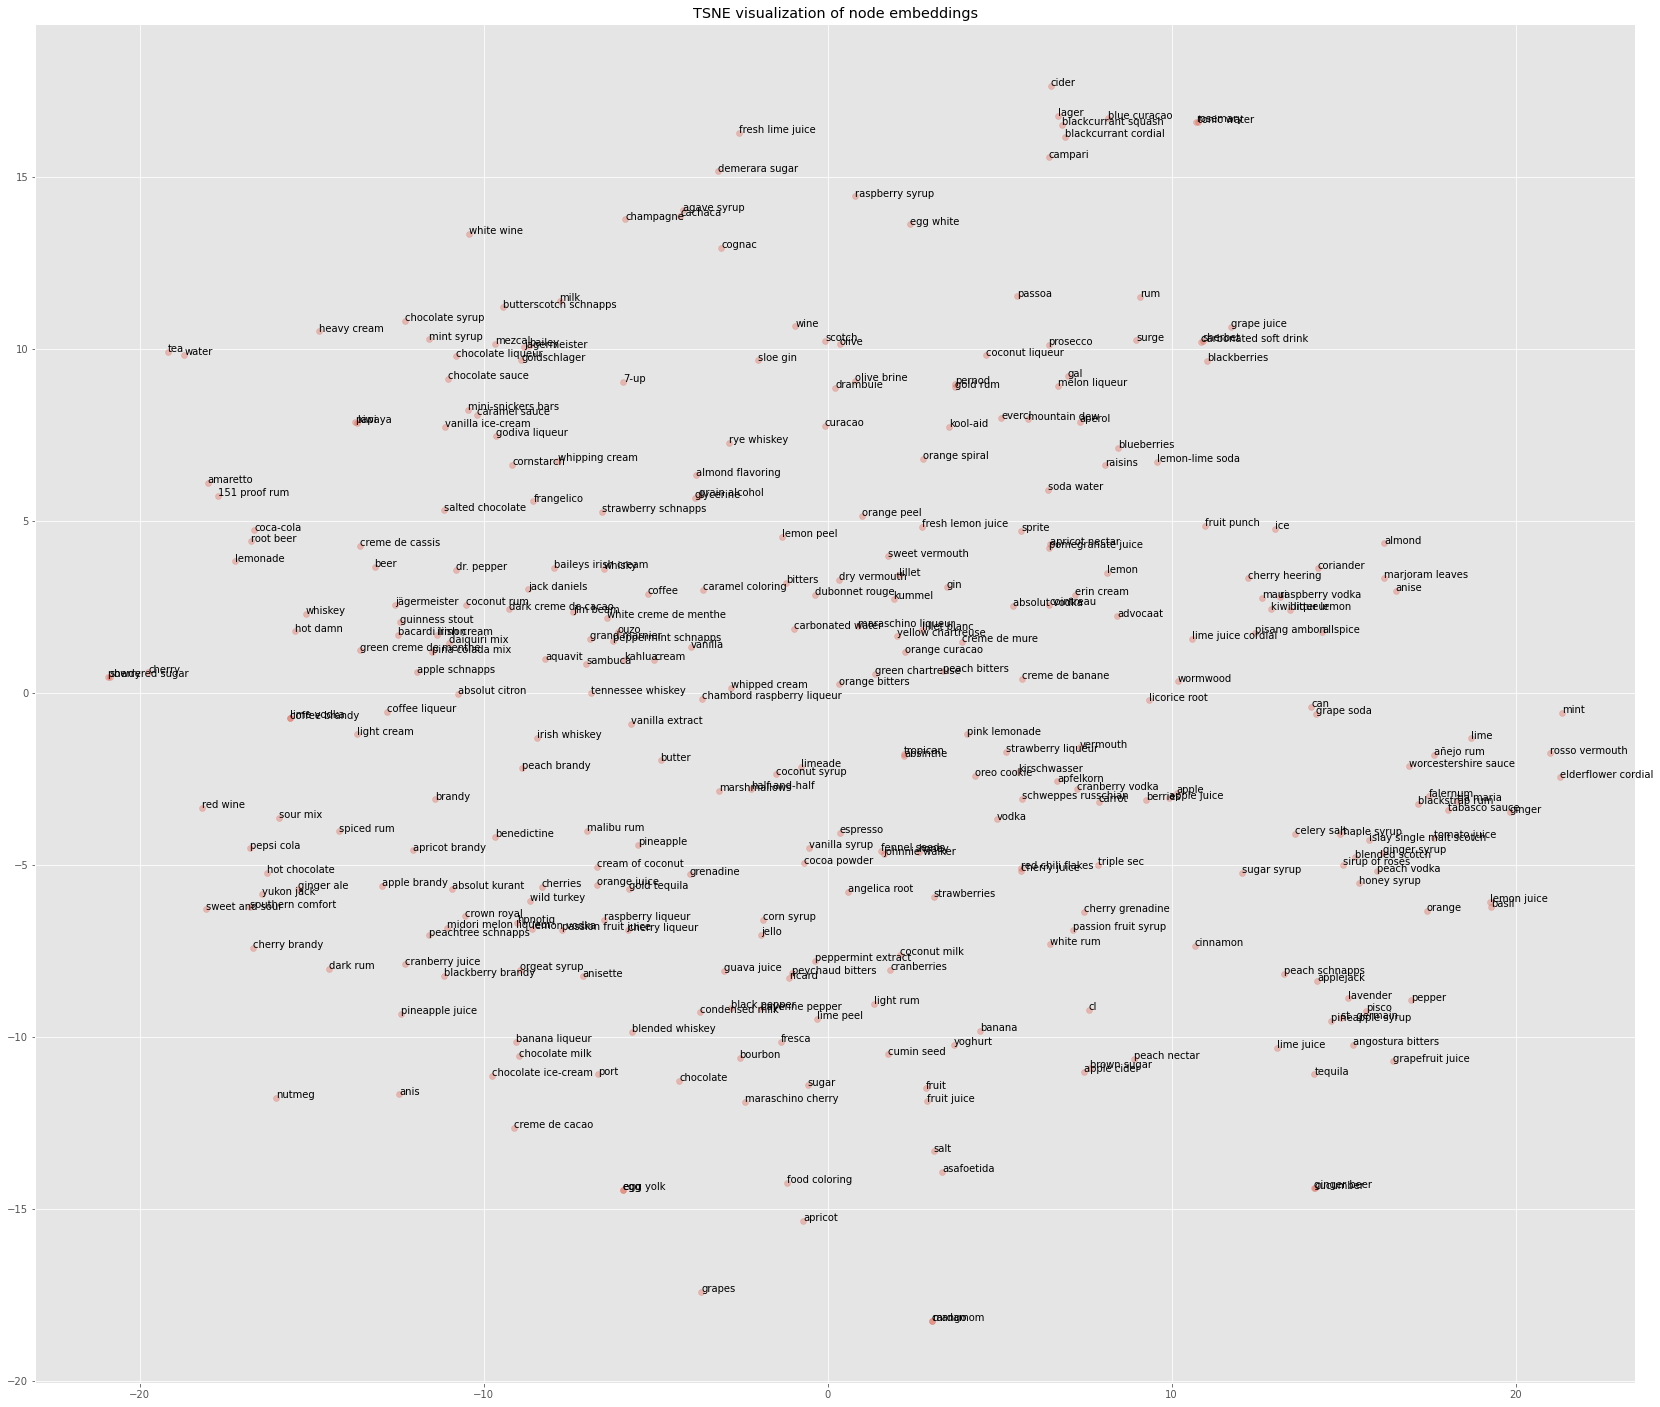

In [344]:
import numpy as np
plt.figure(figsize=(35, 25))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.3)
for i, txt in enumerate(ings):
    plt.annotate(txt, (node_embeddings_2d[:, 0][i], node_embeddings_2d[:, 1][i]))
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [520]:
#cosine distance function between 2 vectors, a and b
def compare(a_vector, b_vector):
    
    
    ma = np.linalg.norm(a_vector)
    mb = np.linalg.norm(b_vector)
    score = (np.matmul(a_vector,b_vector))/(ma*mb)

    return score

In [522]:
#recommend ingredient pairs
def find_pairings(names, top_n_pairings):
    paired_ingredients, scores = [], []
    summed_vector = np.zeros(100)
    for name in names:
        vector = model.wv[name]
        summed_vector += vector
        
    ingredient_vector_dict = {}
    for ing in ings:
        ingredient_vector_dict[ing] = model.wv[ing]
   
    scoring_dict = {}
    for key, val in zip(ingredient_vector_dict.keys(), ingredient_vector_dict.values()):
        score = compare(summed_vector, val)
        scoring_dict[key] = score
    sorted_scoring_dict = dict(sorted(scoring_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    for idx, (key, val) in enumerate(zip(sorted_scoring_dict.keys(), sorted_scoring_dict.values())):
        if idx <= top_n_pairings and key not in names:
            paired_ingredients.append(key)
            scores.append(val)
   
    
    return paired_ingredients, scores

In [523]:
pairings, scores = find_pairings(["ice", "rum"], 5)

In [478]:
print(pairings)

['blueberries', 'mountain dew', 'raspberry vodka', 'evercl']


In [476]:
print(scores)

[0.6117615974176029, 0.5976777913170194, 0.5750401126902207, 0.5525768049921015]


In [541]:
pairings, scores = find_pairings(["egg"], 10)

In [542]:
print(pairings)

['egg yolk', 'marshmallows', 'coconut syrup', 'black pepper', 'apple cider', 'brown sugar', 'bacardi limon', 'green chartreuse', 'guinness stout', 'heavy cream']


In [479]:
 #load the npmi scores for all ingredient-ingredient pairs from the migrators
    with open('data/npmi_pair_scores.pkl', "rb") as f:
        npmi_pair_scores = list(pickle.load(f))

In [524]:
#function to recommend pairing simply using NMPI scores
def recipe_based_pairings(name, top_n_pairings):
    paired_ingredients = []
    for pairing, score in npmi_pair_scores:
        if pairing[0] == name:
            paired_ingredients.append((pairing[1], score))
        elif pairing[1] == name:
            paired_ingredients.append((pairing[0], score))
    #sort list of tuple based on the scores
    paired_ingredients.sort(key=lambda x:x[1])
    #return top_n results
    res = []
    for idx in range(top_n_pairings):
        res.append(paired_ingredients[-1-idx][0])
        
    return res, paired_ingredients
        

In [525]:
pairings1, paired_ingredients = recipe_based_pairings("milk", 10)

In [526]:
pairings1

['chocolate',
 'godiva liqueur',
 'butterscotch schnapps',
 'vanilla extract',
 'mini-snickers bars',
 'caramel sauce',
 'mint syrup',
 'cornstarch',
 'black pepper',
 'cocoa powder']

In [527]:
pairings2, scores = find_pairings(["milk"], 10)

In [528]:
pairings2

['butterscotch schnapps',
 'mezcal',
 'bailey',
 'caramel sauce',
 'mint syrup',
 'goldschlager',
 'mini-snickers bars',
 'godiva liqueur',
 'jagermeister',
 'frangelico']

In [530]:
df = pd.DataFrame([pairings2, pairings1]).T
df.columns = ["Graph-based Suggestions", "Recipe-based Suggestions"]

In [534]:
df

,Graph-based Suggestions,Recipe-based Suggestions
0,butterscotch schnapps,chocolate
1,mezcal,godiva liqueur
2,bailey,butterscotch schnapps
3,caramel sauce,vanilla extract
4,mint syrup,mini-snickers bars
5,goldschlager,caramel sauce
6,mini-snickers bars,mint syrup
7,godiva liqueur,cornstarch
8,jagermeister,black pepper
9,frangelico,cocoa powder
